# Pet Project

В этом проекте решим задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы.

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
!wget "https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/music_dataset.csv"
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

--2023-06-14 19:01:42--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/music_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1321738 (1.3M) [text/plain]
Saving to: ‘music_dataset.csv.1’

music_dataset.csv.1 100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2023-06-14 19:01:42 (21.8 MB/s) - ‘music_dataset.csv.1’ saved [1321738/1321738]



,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
!wget "https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/tracks_info.csv"
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

--2023-06-14 19:01:42--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/tracks_info.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3416170 (3.3M) [text/plain]
Saving to: ‘tracks_info.csv.1’

tracks_info.csv.1   100%[===================>]   3.26M  --.-KB/s    in 0.07s   

2023-06-14 19:01:43 (45.0 MB/s) - ‘tracks_info.csv.1’ saved [3416170/3416170]



,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Реализуем метрику $MAP@k$.**

In [ ]:
def apk(r: List[int], p: List[int], k: int = 20):
  if len(set(r)) != len(r):
    raise ValueError("Values in relevant are not unique")

  if len(set(p)) != len(p):
    raise ValueError("Values in predicted are not unique")

  if k > len(p):
    k = len(p)

  correct_predictions = 0
  running_sum = 0
  for i in range(k):
    rank = i+1
    if p[i] in r:
      correct_predictions += 1
      running_sum += correct_predictions/rank

  return running_sum/min(k, len(r))
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    return np.mean([apk(r, p, k) for r, p in zip(relevant, predicted)])

In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**BaseModel**:
реализуем метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """

        return NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = np.array(preds[user_id])
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for i in range(self.n_users):
          test_preds.append(self.recommend(i))
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]


## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Реализуем функцию подсчета корреляции Пирсона и меры Жаккара**

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    return np.sum(np.logical_and(ratings, user_vector), axis = 1) / np.sqrt(np.sum(ratings, axis = 1) * np.sum(user_vector))

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return np.sum(np.logical_and(ratings, user_vector), axis = 1) / np.sum(np.logical_or(ratings, user_vector), axis = 1)


**User2User**

Реализуем методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector).reshape(-1, 1)

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        mask = sim >= self.alpha
        rec = np.sum(mask * self.R * sim, axis=0)/np.sum(mask * sim, axis = 0)
        return np.argsort(rec)[::-1].tolist()

Построим графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравним их между собой, а также с предсказаниями случайного алгоритма и сделаем выводы.

In [ ]:
model_1 = User2User(train_ratings, pearson)
model_2 = User2User(train_ratings, jaccard)
preds1 = model_1.get_test_recommendations(50)
preds2 = model_2.get_test_recommendations(50)
#1 мин 44 сек

In [ ]:
np.random.seed(1561)
def createRandomSortedList(num, start = 1, end = 100):
    arr = np.random.choice(np.arange(start, end + 1), size=num, replace=False)
    arr.sort()
    return arr
preds3 = createRandomSortedList((235, 50), start = 23, end=67160)

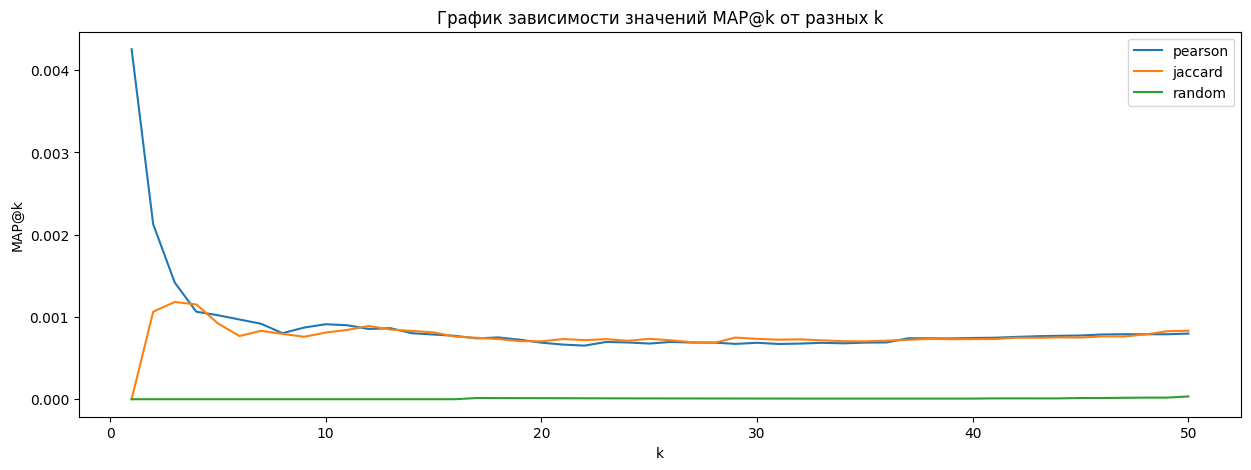

In [ ]:
prsn = []
jc =[]
rndm = []
k = [i for i in range(1, 51)]
for i in range(1, 51):
  prsn.append(mapk(test_relevant, preds1, i))
  jc.append(mapk(test_relevant, preds2,  i))
  rndm.append(mapk(test_relevant, preds3, i))
plt.figure(figsize=(15, 5))
plt.plot(k, prsn, label = 'pearson')
plt.plot(k, jc, label = 'jaccard')
plt.plot(k, rndm, label = 'random')
plt.title('График зависимости значений MAP@k от разных k')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

Вначале функции похожести имеют разные значения map@k. Затем с увеличением k map@k для функций похожести pearson и jacard, начиная с k=9 map@k стабилен. А для рандомного алгоритма map@k постоянный и равен нулю или имеет близкое к нулю значение. И сами значения map@k разреженные

Как можно заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишем код так, чтобы все методы могли работать с разреженными матрицами и сравним скорость работы такого подхода с оригинальным.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.R = scs.csr_matrix(self.R)
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """

        return NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = np.array(preds[user_id])
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for i in range(self.n_users):
          test_preds.append(self.recommend(i))
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

def pearson(ratings: scs.csr_array, user_vector: scs.csr_array) -> scs.csr_array:
    return ratings * user_vector.reshape(-1, 1) / np.sqrt(np.sum(ratings, axis = 1) * np.sum(user_vector)) # необязательно возводить в квадрат для нашей задачи

def jaccard(ratings: scs.csr_array, user_vector: scs.csr_array) -> scs.csr_array:
    repeat = scs.csr_matrix(np.ones((ratings.shape[0], 1))) * user_vector
    unite = ratings*user_vector.reshape(-1,1)
    return unite / (np.sum(ratings + repeat, axis = 1) - unite)


class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return scs.csr_matrix(self.similarity_func(self.R, user_vector))

    def recommend(self, uid: int):
        sim = self.similarity(self.R[[uid], :])
        mask = sim >= self.alpha
        rec = np.sum(self.R.multiply(mask).multiply(sim), axis = 0) / np.sum(sim.multiply(mask), axis = 0)
        rec = np.array(rec).squeeze(0)
        return np.argsort(rec)[::-1].tolist()

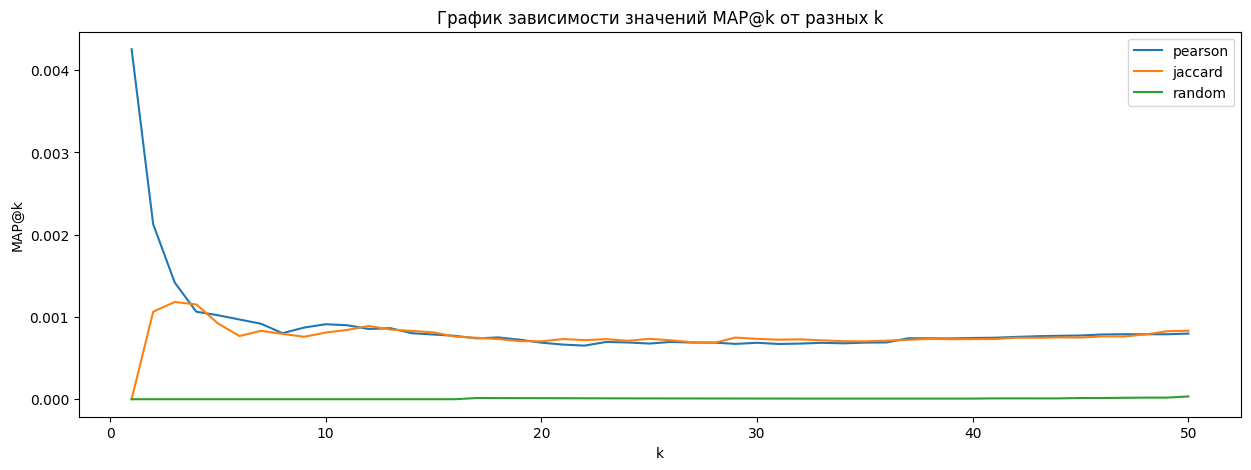

In [ ]:
# 19 сек
model_1 = User2User(train_ratings, pearson)
model_2 = User2User(train_ratings, jaccard)
preds1 = model_1.get_test_recommendations(50)
preds2 = model_2.get_test_recommendations(50)
prsn = []
jc = []
rndm = []
k = [i for i in range(1, 51)]
for i in range(1, 51):
  prsn.append(mapk(test_relevant, preds1, i))
  jc.append(mapk(test_relevant, preds2,  i))
  rndm.append(mapk(test_relevant, preds3, i))
plt.figure(figsize=(15, 5))
plt.plot(k, prsn, label = 'pearson')
plt.plot(k, jc, label = 'jaccard')
plt.plot(k, rndm, label = 'random')
plt.title('График зависимости значений MAP@k от разных k')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя.


In [ ]:
model = User2User(train_ratings, jaccard)
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
234,Wind Of Change,['Scorpions']
610,Close To Me,['The Cure']
611,In Between Days,['The Cure']
630,Every Breath You Take,['The Police']
800,Mr. Brightside,['The Killers']
1297,Flashing Lights,"['Kanye West', 'Dwele']"
1647,My Boy Builds Coffins,['Florence + The Machine']
1649,Cosmic Love,['Florence + The Machine']
3217,Rock & Roll Queen,['The Subways']
3413,Suddenly I See,['KT Tunstall']


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
49577,Кукла колдуна,['Король и Шут']
45208,Беспечный ангел,['Ария']
5872,Я свободен,['Кипелов']
15242,Батарейка,['Жуки']
234,Wind Of Change,['Scorpions']
9438,Что такое осень,['ДДТ']
3235,U Can't Touch This,['MC Hammer']
10282,Владивосток 2000,['Мумий Тролль']
14484,Прогулки по воде,['Nautilus Pompilius']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
50565,Social Cues,['Cage The Elephant']
50697,Karma,['AJR']
50756,LOVE IT ритм,['MONATIK']
52627,Beautiful People,"['Ed Sheeran', 'Khalid']"
53718,Teeth,['5 Seconds of Summer']
54483,When I R.I.P.,['Labrinth']
55387,Ludens,['Bring Me The Horizon']
56030,Heartless,['The Weeknd']
56031,Blinding Lights,['The Weeknd']
56168,Пусть они умрут,"['Anacondaz', 'Noize MC']"


Получилось не хорошо, если смотреть на релевантные треки и сравнить прослушанные с рекомендованными

## Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

Есть два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведем формулы обновления параметров для обоих методов.

**LFM:**

Найдем градиенты по каждому параметру:
$$ \frac{\delta L}{\delta p_u} = \sum_{(i) \in I} 2( \hat r_{ui} - r_{ui} ) q_i + 2 λ p_u $$
$$ \frac{\delta L}{\delta q_i} = \sum_{(u) \in U} 2( \hat r_{ui} - r_{ui} ) p_u + 2 λ q_i $$
Теперь выведем формулы обновления параметров:
$$ p_u := p_u - α  [\sum_{(i) \in I} 2( \hat r_{ui} - r_{ui} ) q_i + 2 λ p_u] $$
$$ q_i := q_i - α  [\sum_{(u) \in U} 2( \hat r_{ui} - r_{ui} ) p_u + 2 λ q_i] $$
, где $\alpha \, - $ learning rate

**ALS:**

с регуляризацией:
$$ p_u :=  (\sum_{(i) \in I}  q_i q_i^T + \lambda p_u)^{-1} {\sum_{(i) \in I}  r_{ui} q_i} $$
$$ q_i :=  (\sum_{(u) \in U}  p_i p_i^T + \lambda q_i)^{-1} {\sum_{(u) \in U}  r_{ui} p_u} $$



Реализуем методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """

        return NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = np.array(preds[user_id])
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for i in range(self.n_users):
          test_preds.append(self.recommend(i))
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                user_id = np.random.randint(self.n_users)
                item_id = np.random.randint(self.n_items)
                if epoch % 500 == 0:
                  loss = np.sum((self.R - self.P @ self.Q.T) ** 2) + self.lamb * (np.sum(self.P ** 2) + np.sum(self.Q ** 2))
                error = self.R[user_id, item_id] - self.P[user_id] @ self.Q[item_id].T + self.lamb * (np.sum(self.P[user_id] ** 2) + np.sum(self.Q[item_id] ** 2))
                self.P[user_id] += self.lr * (self.Q[item_id] * error)
                self.Q[item_id] += self.lr * (self.P[user_id] * error)
            elif self.mode == 'als':
                for user_id in range(self.n_users):
                  mask_q = self.Q[self.R[user_id].astype(bool)]
                  d_p = np.sum(mask_q * mask_q, axis = 0)
                  n_p = np.sum(mask_q, axis = 0)
                  self.P[user_id] = n_p / d_p
                for item_id in range(self.n_items):
                  mask_p = self.P[self.R[:, item_id].astype(bool)]
                  d_q = np.sum(mask_p * mask_p, axis = 0)
                  n_q = np.sum(mask_p, axis = 0)
                  self.Q[item_id] = n_q / d_q
                if epoch % 2 == 0:
                  loss = np.sum((self.R - self.P @ self.Q.T) ** 2) + self.lamb * (np.sum(self.Q ** 2) + np.sum(self.P ** 2))


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

Для обоих алгоритмов подберем оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Построим соответствующие графики, сравним со случайным подходом и User2User, сделаем выводы.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

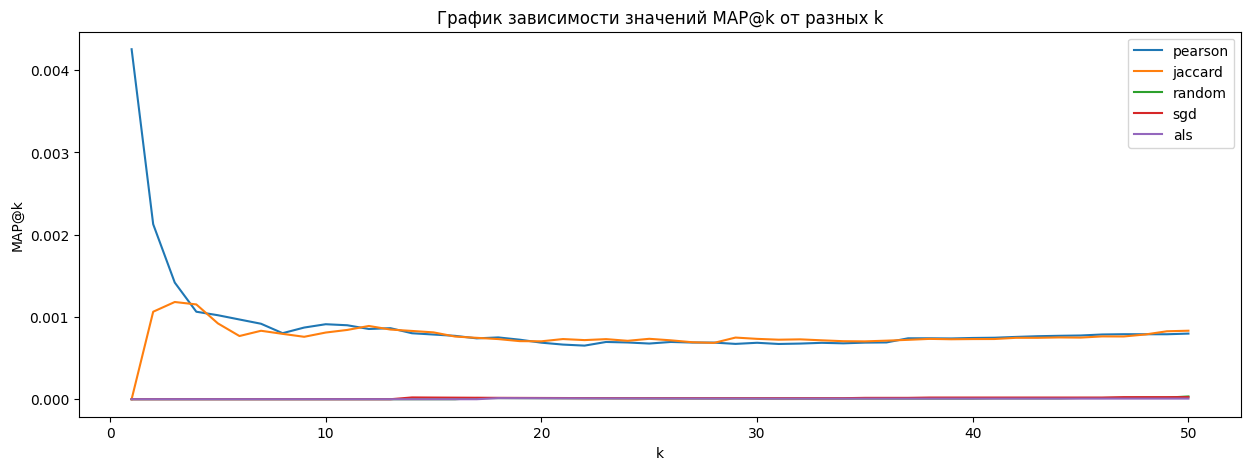

In [ ]:
model3 = HiddenVars(train_ratings, 50 , 'sgd')
model3.fit(10)
model4 = HiddenVars(train_ratings, 100, 'als')
model4.fit(5)
preds4 = model3.get_test_recommendations(50)
preds5 = model4.get_test_recommendations(50)

sgd = []
als = []

k = [i for i in range(1, 51)]
for i in range(1, 51):
  sgd.append(mapk(test_relevant, preds4, i))
  als.append(mapk(test_relevant, preds5, i))
plt.figure(figsize=(15, 5))
plt.plot(k, prsn, label = 'pearson')
plt.plot(k, jc, label = 'jaccard')
plt.plot(k, rndm, label = 'random')
plt.plot(k, sgd, label = 'sgd')
plt.plot(k, als, label = 'als')
plt.title('График зависимости значений MAP@k от разных k')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

Как будто качество не очень хорошее , качество als подхода не изменяется с увеличением итераций, а для sgd незначительно улучшается
Дальше на тесте ниже sgd показывает хорошие результаты, так что  выберем для решения этой задачи метод LFM

При оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model3.Q @ model3.Q[example_trackId]
preds = preds / np.sqrt((model3.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model3.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
66739,INFERNO,"['Sub Urban', 'Bella Poarch']",0.627873
33113,Black Tears,"['Imelda May', 'Jeff Beck']",0.601643
54281,Primal Instinct,"['Angerfist', 'Sterotype']",0.551347
34743,Prologue,"['Original Broadway Company of Natasha, Pierre...",0.506979
54296,Рок,['Г.М.О.'],0.501867
7707,Einsamer Hirte,['Edward Simoni'],0.495224
54984,Skeletun,['Tekno'],0.492612
37802,I Get By,['Liam Gallagher'],0.488584
2737,A Gunshot to the Head of Trepidation,['Trivium'],0.484204
